# 总结：

采用在ImageNet上预训练的MobileNet Model提取出来的Semantic Feature作为输入，连接一个全连接层，对照片进行美观度区分。

整体分类准确率基本维持在68%-69%之间。其中：
1. 正样本预测准确率为72%，召回率为61%
2. 负样本预测准确率为66%，召回率为76%

从预测结果来看，该模型对风景和人文类主题的照片有着较为明显的偏好。可能是这类照片有着较为明确的主体。

## 训练

In [1]:
from keras.models import Model, Sequential, save_model, load_model
from keras.layers import Input, Dense, Activation, Add, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras import optimizers
import keras.backend as K
import numpy as np

Using TensorFlow backend.


In [2]:
aesthetic_model = Sequential([
    Dense(512, activation="selu", input_shape=(1024,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
aesthetic_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

aesthetic_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 527,361
Trainable params: 526,337
Non-trainable params: 1,024
_________________________________________________________________


In [3]:
import pandas as pd
import lmdb
import random

trainset = pd.read_csv("./data/train.lst", 
                       dtype={"imgid": np.str, "rating": np.float, "label": np.int}).values.tolist()
testset = pd.read_csv("./data/test.lst", 
                      dtype={"imgid": np.str, "rating": np.float, "label": np.int}).values.tolist()
env = lmdb.open("../generic_features/data/semantic_features.lmdb/")
txn = env.begin()
batch_size = 64

def get_feature(imgid):
    str_feature = txn.get(imgid)
    return np.fromstring(str_feature, np.float32)

def generate_batch(dataset, batch_size, shuffle=True):
    while True:
        if shuffle:
            random.shuffle(dataset)
            
        for index in range(0, len(dataset), batch_size):
            if index + batch_size > len(dataset):
                current_batch_size = len(dataset) - index
            else:
                current_batch_size = batch_size
            index_array = dataset[index:index+current_batch_size]
            
            batch_x = np.zeros((current_batch_size, 1024), dtype=K.floatx())
            batch_y = np.zeros((current_batch_size, ), dtype=K.floatx())
            for i, (imgid, rating, label) in enumerate(index_array):
                x = get_feature(imgid)
                batch_x[i] = x
                batch_y[i] = label
            yield (batch_x, batch_y)

In [5]:
aesthetic_model.fit_generator(generate_batch(trainset, batch_size), 
                              steps_per_epoch=len(trainset) // batch_size, 
                              validation_data=generate_batch(testset, batch_size), 
                              validation_steps=len(testset) // batch_size,
                              epochs=5)

Epoch 1/5
2070/2070 [==============================] - 6s - loss: 0.5711 - acc: 0.7002 - val_loss: 0.5838 - val_acc: 0.6903
Epoch 2/5
2070/2070 [==============================] - 6s - loss: 0.5660 - acc: 0.7042 - val_loss: 0.5911 - val_acc: 0.6837
Epoch 3/5
2070/2070 [==============================] - 6s - loss: 0.5608 - acc: 0.7086 - val_loss: 0.5865 - val_acc: 0.6876
Epoch 4/5
2070/2070 [==============================] - 6s - loss: 0.5539 - acc: 0.7149 - val_loss: 0.5961 - val_acc: 0.6840
Epoch 5/5
2070/2070 [==============================] - 6s - loss: 0.5476 - acc: 0.7197 - val_loss: 0.5949 - val_acc: 0.6913


In [6]:
save_model(aesthetic_model, "./model/mobilenet.h5")

## 预测

In [7]:
aesthetic_model = load_model("./model/mobilenet.h5")

In [8]:
testset = pd.read_csv("./data/test.lst", 
                      dtype={"imgid": np.str, "rating": np.float, "label": np.int})

imgids = testset.imgid.values
ratings = testset.rating.values
labels = testset.label.values
probs = aesthetic_model.predict_generator(generate_batch(testset.values.tolist(), batch_size, shuffle=False),
                                  steps = len(testset) // batch_size + 1)[:, 0]
preds = (probs > 0.5).astype(np.int)

In [9]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import random

n_view = 10
img_path = "../dataset/AVA/imgs/"
def imgPlot(imgid, title):
    plt.figure()
    
    plt.title("%s"%title)
    img = Image.open(img_path+"%s.jpg"%imgid)
    plt.imshow(img)
    plt.axis('off')
    
    plt.show()

- The images we most confident were beautiful, and are actually beautiful

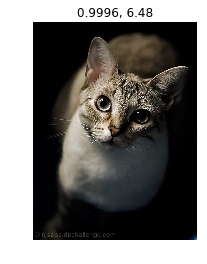

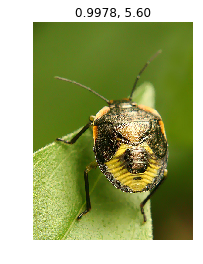

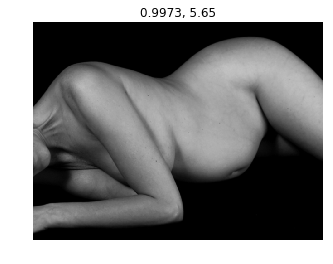

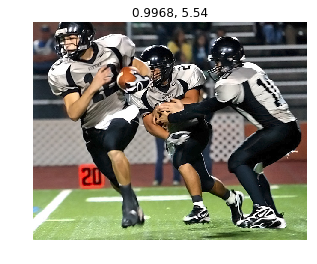

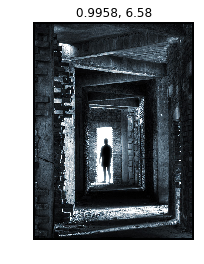

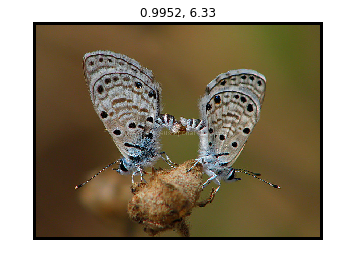

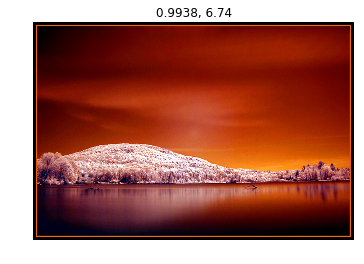

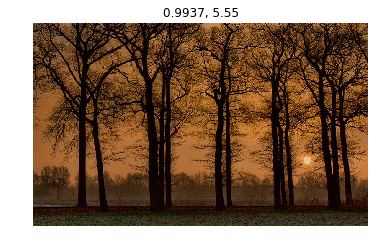

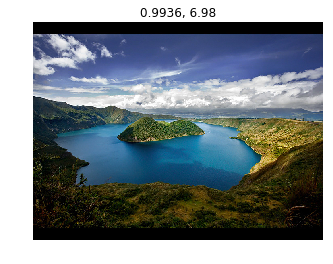

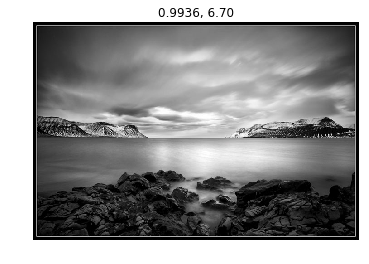

In [10]:
correct_imgs = np.where((preds==1) & (labels==1))[0]
most_correct_imgs = np.argsort(probs[correct_imgs])[::-1][:n_view]
for idx in correct_imgs[most_correct_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The images we most confident were ugly, and are actually ugly

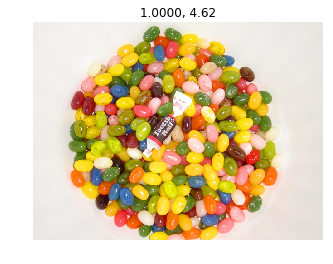

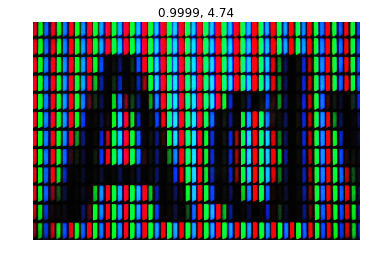

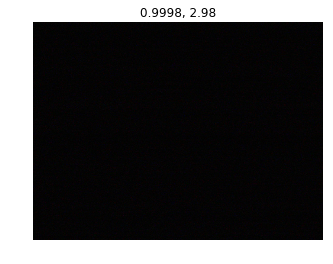

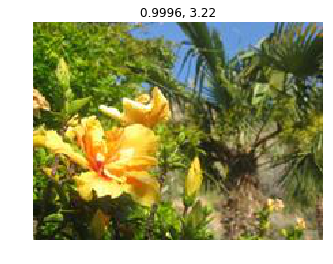

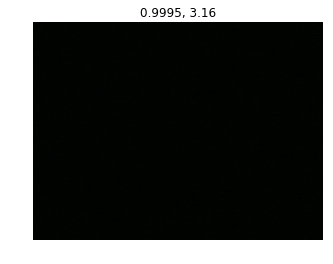

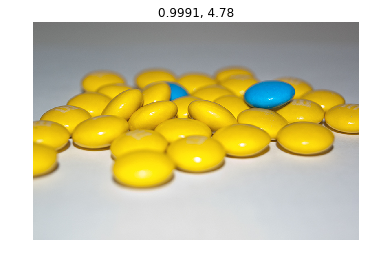

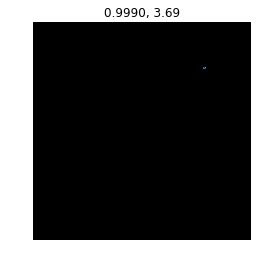

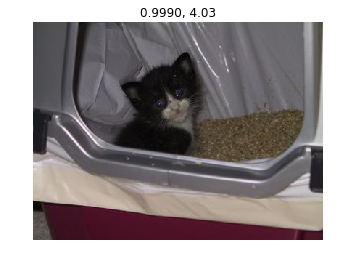

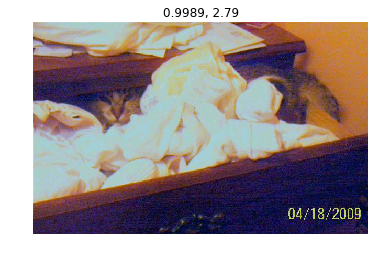

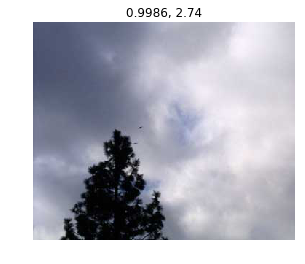

In [11]:
correct_imgs = np.where((preds==0) & (labels==0))[0]
most_correct_imgs = np.argsort(probs[correct_imgs])[:n_view]
for idx in correct_imgs[most_correct_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(1-probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The images we most confident were beautiful, but are actually ugly

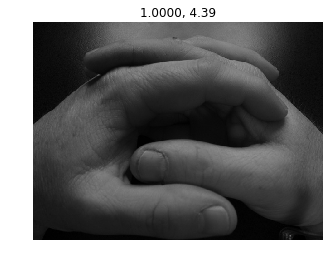

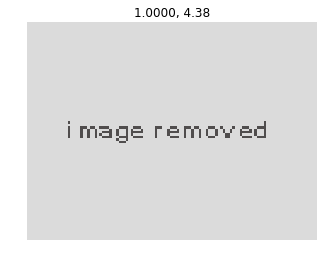

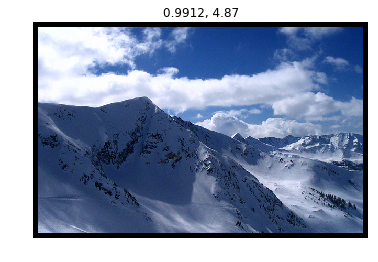

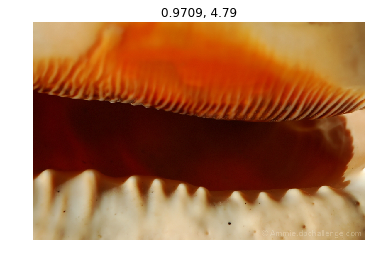

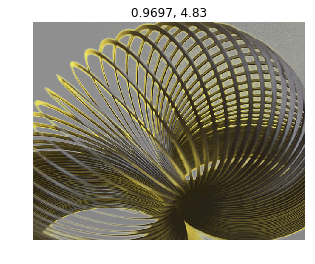

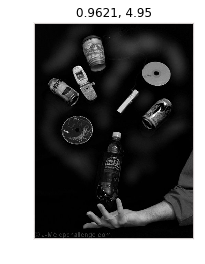

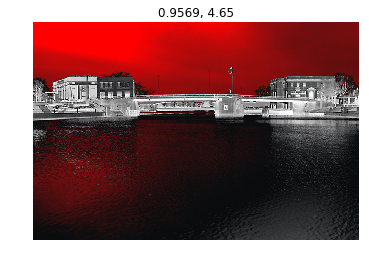

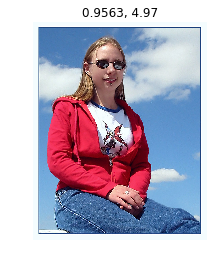

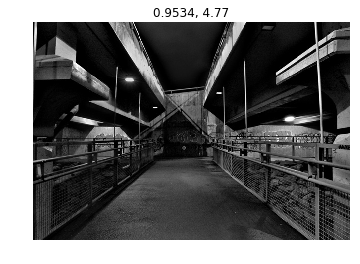

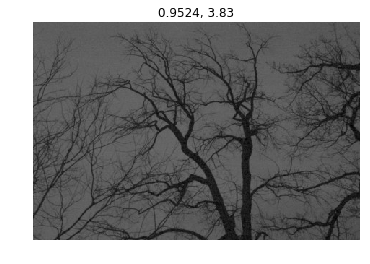

In [12]:
incorrect_imgs = np.where((preds==1) & (labels==0))[0]
most_incorrect_imgs = np.argsort(probs[incorrect_imgs])[::-1][:n_view]
for idx in incorrect_imgs[most_incorrect_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The images we most confident were ugly, but are actually beautiful

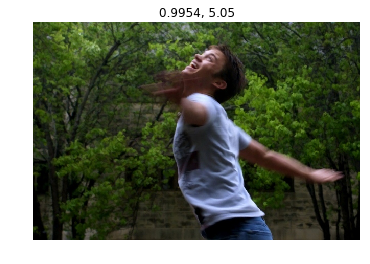

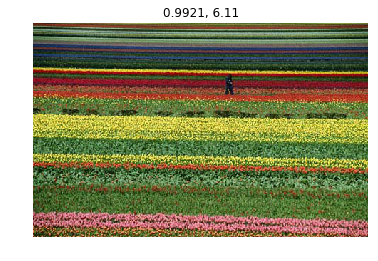

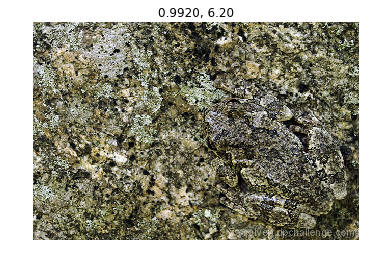

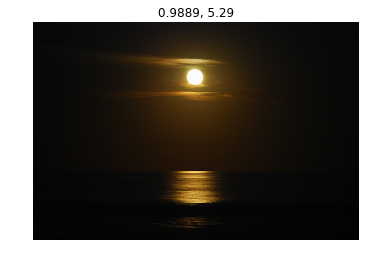

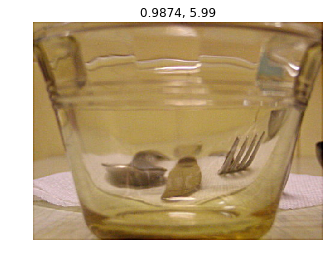

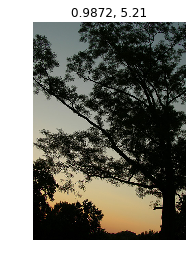

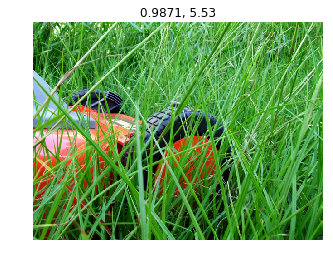

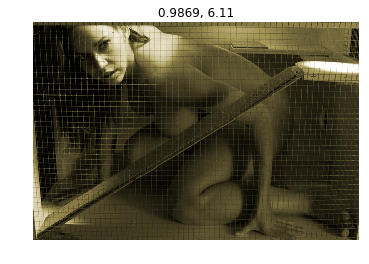

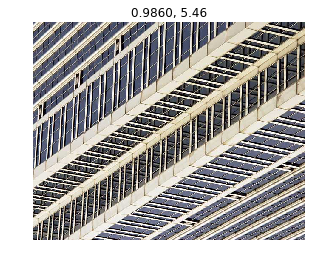

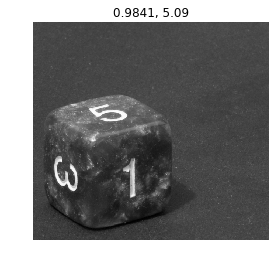

In [13]:
incorrect_imgs = np.where((preds==0) & (labels==1))[0]
most_incorrect_imgs = np.argsort(probs[incorrect_imgs])[:n_view]
for idx in incorrect_imgs[most_incorrect_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(1-probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The most uncertain labels (ie those with probability closest to 0.5).

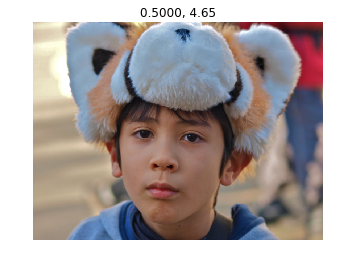

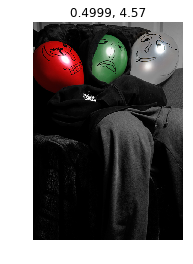

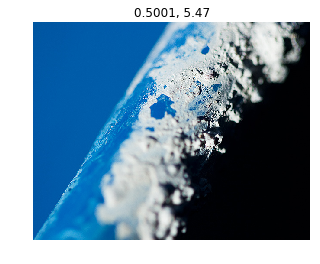

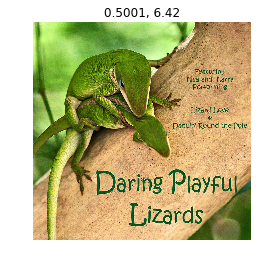

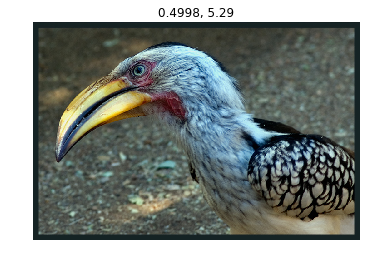

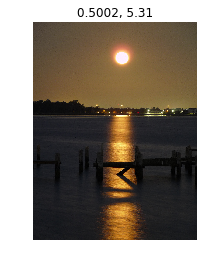

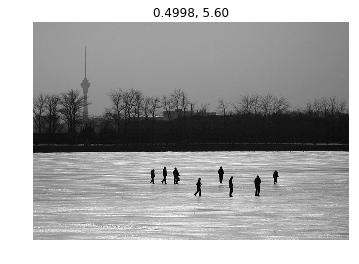

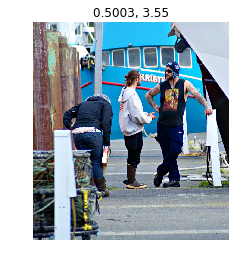

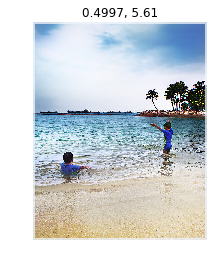

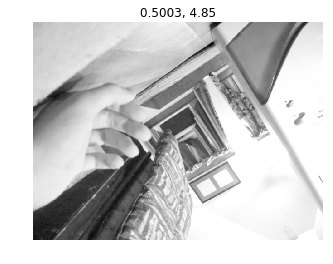

In [14]:
most_uncertain = np.argsort(np.abs(probs-0.5))[:n_view]
for idx in most_uncertain:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(probs[idx], ratings[idx])
    imgPlot(imgid, title)

- confusion matrix

[[5658 1743]
 [2860 4541]]


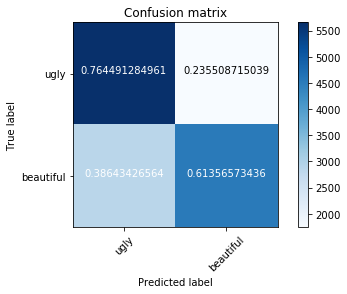

In [26]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(labels, preds)
print(cm)
plot_confusion_matrix(cm, ["ugly", "beautiful"], normalize=True)

In [32]:
cm.astype('float') / cm.sum(axis=0)

array([[ 0.66424043,  0.2773711 ],
       [ 0.33575957,  0.7226289 ]])